In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import os
import matplotlib.colors as clrs
from IPython.core.display import display, HTML
import anndata
from sklearn.metrics import silhouette_score
from joblib import parallel_backend
import math
import re
import pickle

/tmp/ipykernel_666125/1701034591.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
sc.settings.verbosity=0
sc.settings.set_figure_params(dpi=100)
sc.logging.print_versions()

-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                 10.4.0
asttokens           NA
bottleneck          1.3.7
cffi                1.15.1
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.2.0
executing           0.8.3
h5py                3.12.1
igraph              0.11.6
ipykernel           6.28.0
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.7
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
matplotlib          3.9.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.8.7
numpy               1.26.3
packaging           23.0
pandas              2.2.2
parso               0.8.3
patsy               0.5.6
pkg_resources       NA
platformdirs        3.10.0
plotly              6.0.1
prompt_toolkit      3.0.43
psutil     

In [3]:
colors = [(0, ("#E0E0E0")), (0.25, ("#F1F1F1")), (1,("#FD0D0D"))]
n_bins = 250 # discretizes the interpolation into bins
cmap_name = "new_list"
cm_2 = clrs.LinearSegmentedColormap.from_list(cmap_name, colors , N = n_bins)

In [4]:
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [5]:
# load adata objects of polyclonal cancer cell lines
with open("/group/iorio/Raffaele/SCDRESP_data/data/adata_dict.pkl", "rb") as f:
    adata_paths=pickle.load(f)

In [6]:
sub_adata_cl_dict = {key: anndata.read_h5ad(path) for key, path in adata_paths.items()}

In [7]:
# load pipeline results
df = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/filtered_clustering_res.csv")

In [8]:
# load datasets
gdscat2=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/gdsc/GDSCatSquare-009_matrix_results.csv")
gdsc=pd.read_excel("/group/iorio/Raffaele/SCDRESP_data/data/gdsc/GDSC2_fitted_dose_response.xlsx")
gdsc.rename(columns={"SANGER_MODEL_ID":"SangerModelID"},inplace=True)
gex=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/ccle/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv",index_col=0)
genes=[re.sub(r"\s*\(.*?\)", "", gene) for gene in gex.columns]
gex.columns=genes
gex=gex.reset_index().rename(columns={"index":"ModelID"})

In [9]:
model_broad=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/Model.csv")
model_broad=model_broad[["ModelID","SangerModelID","OncotreeSubtype","COSMICID","OncotreeLineage"]]

In [10]:
gex_extended = gex.merge(model_broad, on="ModelID", how="left")

In [11]:
gene_lengths=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/gene_lengths.csv", index_col=0)
gene_lengths.set_index("Gene_Name", inplace=True)

In [12]:
otreelineage_sc = {k: v.obs["OncotreeLineage"].cat.categories[0] for k,v in sub_adata_cl_dict.items()}

In [13]:
# Aggregate single-cell profiles and normalize data

sub_adata_aggrGEPs_cl_dict = {}

for CL, adata in sub_adata_cl_dict.items():
    if CL in df["CellLine"].unique():
        #print(f'Sanger Model ID : {CL}') 
        cell_data = df.loc[df["CellLine"] == CL].iloc[0]
        nHVG = cell_data["nHVG"]
        method = cell_data["cl_method"]
        var = cell_data["res"] if method == "leiden" else cell_data["cl"]
        cl_key = f"{method}_{nHVG}_{var}_clusters"
        read_counts = adata.layers["counts"]
    
        if hasattr(read_counts, "toarray"):
            read_counts = read_counts.toarray()
    
        counts_df = pd.DataFrame(read_counts, index=adata.obs_names, columns=adata.var_names)
    
        # Aggregate
        aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).mean()
        genes = aggr_counts_df.columns.intersection(gene_lengths.index)
        len_genes = gene_lengths[gene_lengths.index.isin(genes)]["Length"]
        len_genes = len_genes[~len_genes.index.duplicated(keep="first")]
        aggr_counts_df = aggr_counts_df.loc[:,genes]
    
        # Normalize
        rpk = aggr_counts_df.div(len_genes, axis=1)  # Reads Per Kilobase
        total_rpk = rpk.sum(axis=1)  # Sum of all RPK values per sample
        tpm = rpk.div(total_rpk, axis=0) * 1e6  # Scale to TPM
    
        # Convert to anndata for an easier manipulation
        adata_aggr = sc.AnnData(tpm)
        sub_adata_aggrGEPs_cl_dict[CL] = adata_aggr

# combine adata objcts
adata_combined = sc.concat(list(sub_adata_aggrGEPs_cl_dict.values()), join="inner", label="ID", keys=list(sub_adata_aggrGEPs_cl_dict.keys()))
sc_TPM = pd.DataFrame(adata_combined.X, index=adata_combined.obs_names, columns=adata_combined.var_names)
sc_TPM["CellLine"] = adata_combined.obs["ID"].values
sc_TPM["Clone_ID"] = sc_TPM["CellLine"].astype(str) + "_clone_" + sc_TPM.index.astype(str)
sc_TPM.reset_index(inplace=True, drop=True)

/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).mean()
/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).mean()
/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs

/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).mean()
/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).mean()
/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs

/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).mean()
/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).mean()
/tmp/ipykernel_666125/1363397991.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs

In [14]:
sc_TPM["OncotreeLineage"] = sc_TPM["CellLine"].map(otreelineage_sc)

In [15]:
dataset_A=sc_TPM.iloc[:,:-3]
dataset_A_columns = sorted(dataset_A.columns)

In [16]:
dataset_B=gex_extended.iloc[:,1:-4]
dataset_B_columns = sorted(dataset_B.columns)

In [17]:
genes_in_common = [gene for gene in dataset_A_columns if gene in dataset_B_columns]

In [18]:
dataset_A=dataset_A.loc[:,genes_in_common]
dataset_A=np.log1p(dataset_A)+1

In [19]:
dataset_B.index = gex_extended["SangerModelID"].values
dataset_B=dataset_B.loc[:,genes_in_common]

In [20]:
dataset_B["tissue"] = gex_extended["OncotreeLineage"].values
dataset_A["type"] = "sc pseudoclones"
dataset_A["SangerModelID"] = sc_TPM["CellLine"]
dataset_A["tissue"] = sc_TPM["OncotreeLineage"]
dataset_B["type"] = "bulk"
dataset_B["SangerModelID"] = dataset_B.index
dataset_C = pd.concat([dataset_A, dataset_B])
dataset_C = dataset_C.reset_index(drop=True)

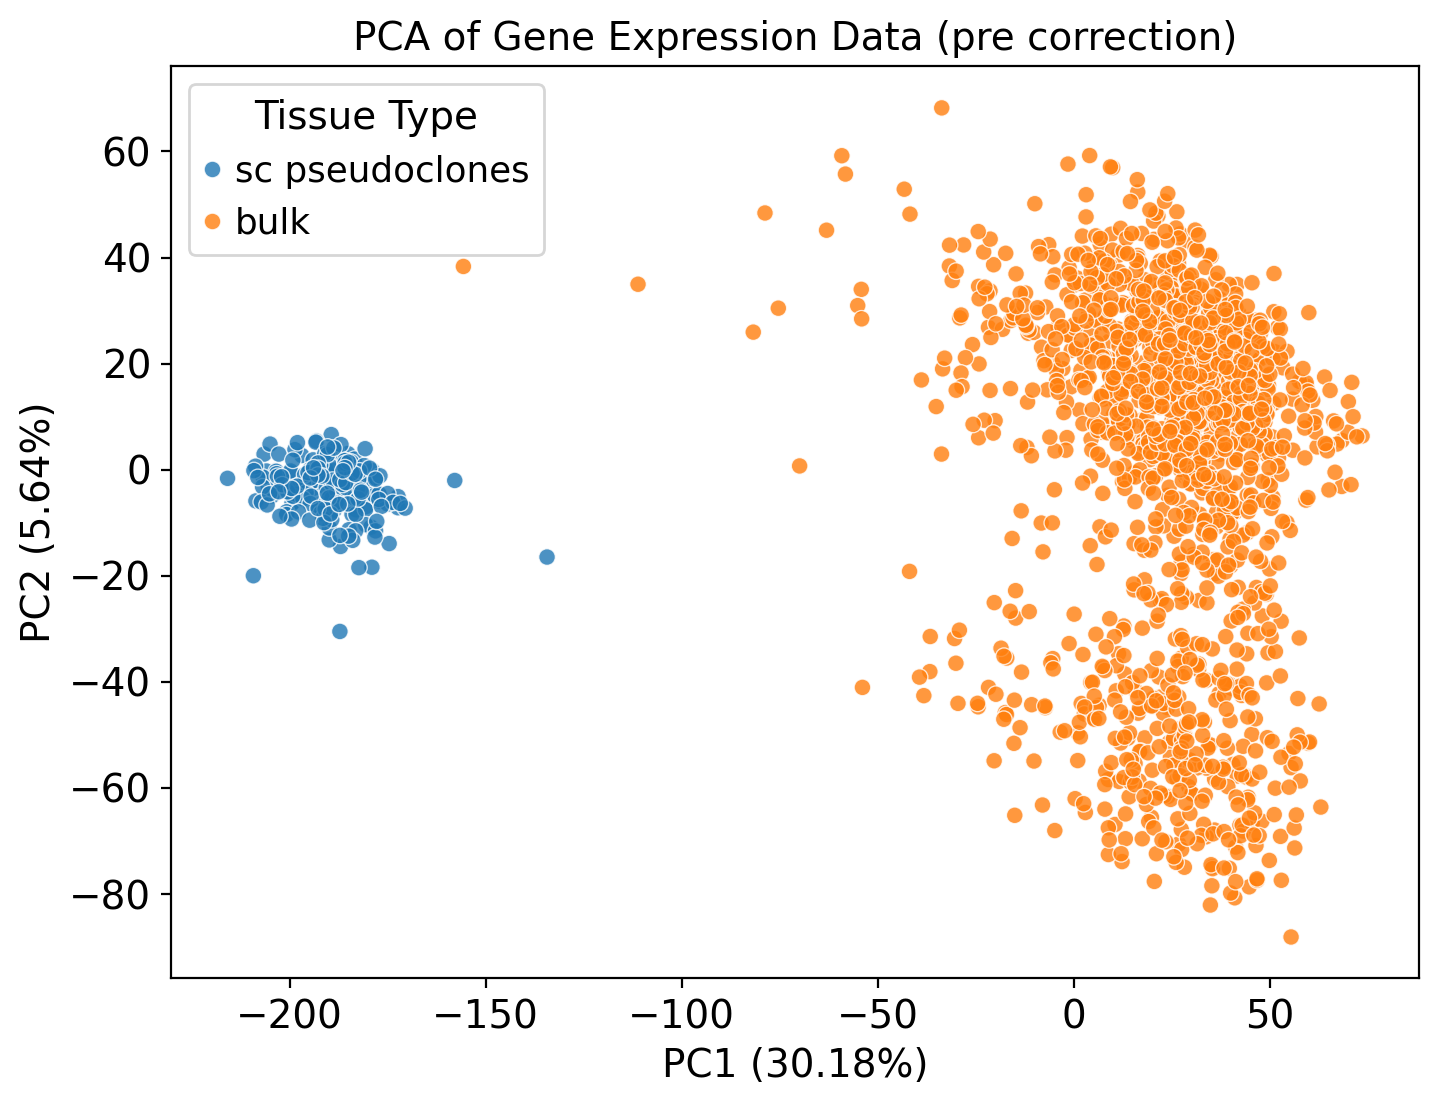

In [21]:
# Visualize batch effect
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the dataset
scaler = StandardScaler()
scaled_C_df = scaler.fit_transform(dataset_C.iloc[:, :-3])

# Perform PCA
pca = PCA(n_components=2)
pc_transformed = pca.fit_transform(scaled_C_df)

# Compute variance explained in percentage
explained_variance = pca.explained_variance_ratio_ * 100

# Create DataFrame with labeled PCs including variance explained
df_pca = pd.DataFrame(pc_transformed, columns=[f"PC{i+1} ({var:.2f}%)" for i, var in enumerate(explained_variance)])

# Reset index for merging with dataset_C
df_pca = df_pca.reset_index(drop=True)
dataset_C = dataset_C.reset_index(drop=True)

# Add back the "type" column
df_pca["type"] = dataset_C["type"]

# Plot PCA with variance explained in axis labels
fig, ax = plt.subplots(figsize=(8,6))  
sns.scatterplot(data=df_pca, x=df_pca.columns[0], y=df_pca.columns[1], hue="type", alpha=0.8, ax=ax)
plt.title("PCA of Gene Expression Data (pre correction)")
plt.legend(title="Tissue Type")
plt.grid()
plt.show()

In [22]:
scaled_C_df = pd.DataFrame(scaled_C_df)
scaled_C_df["type"] = dataset_C["type"]
scaled_C_df["tissue"] = dataset_C["tissue"]
scaled_C_df["SangerModelID"] = dataset_C["SangerModelID"]

In [23]:
scaler = StandardScaler()
data_C_scaled = pd.DataFrame(scaler.fit_transform(scaled_C_df.iloc[:,:-3]))
data_C_scaled["type"] = dataset_C["type"]
cmat = data_C_scaled.groupby("type").apply(lambda g: g.iloc[:, :-1].T.corr())
tissue_map = dict(zip(scaled_C_df.index, scaled_C_df["tissue"].values))

/tmp/ipykernel_666125/3072022034.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cmat = data_C_scaled.groupby("type").apply(lambda g: g.iloc[:, :-1].T.corr())


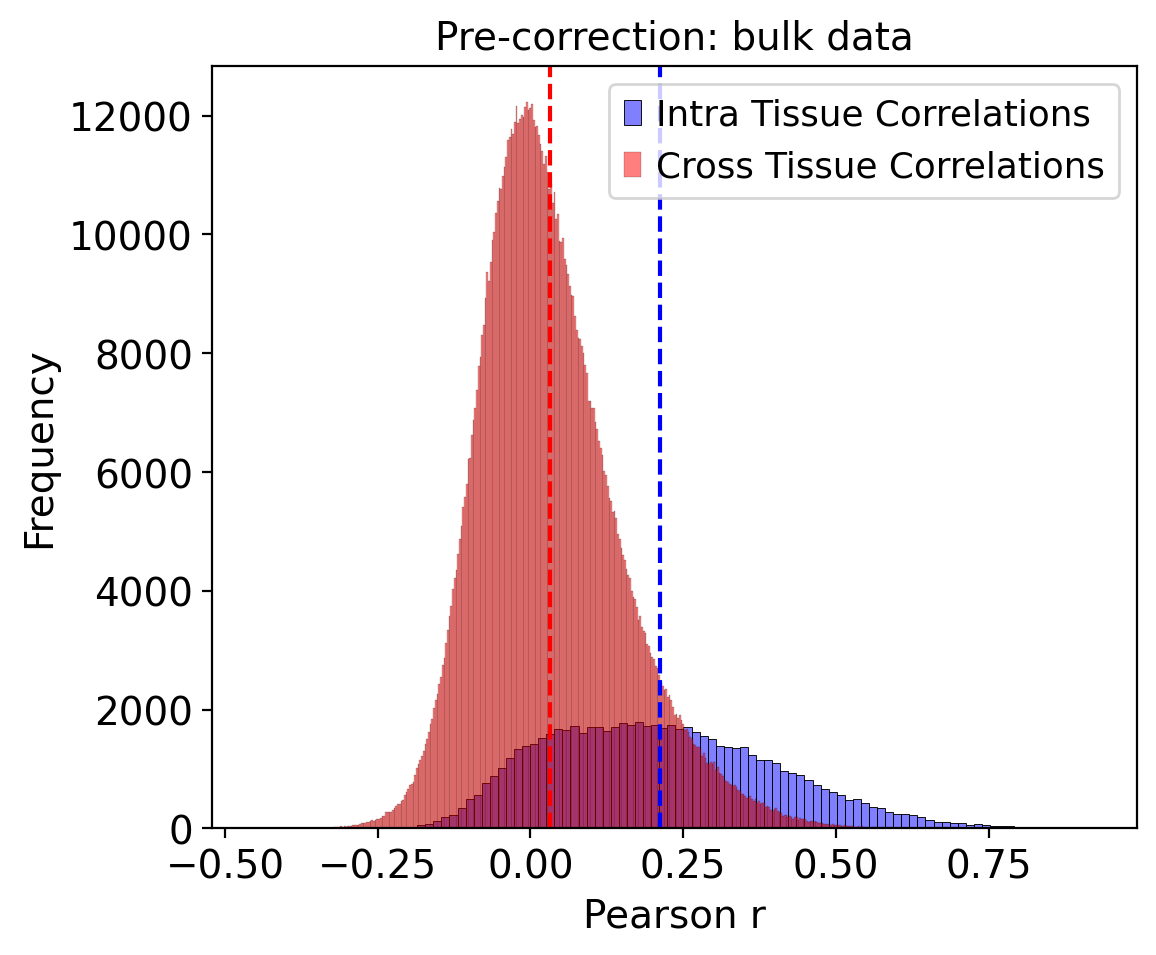

In [24]:
bulk_cmat = cmat.loc["bulk"].dropna(axis=1)
mask = np.triu(np.ones(bulk_cmat.shape), k=1).astype(bool)
cmat_upper = bulk_cmat.where(mask)
bulk_corr = cmat_upper.stack().reset_index()
bulk_corr.columns = ["idx_1", "idx_2", "corr"]
bulk_corr["tissue_1"] = bulk_corr["idx_1"].map(tissue_map)
bulk_corr["tissue_2"] = bulk_corr["idx_2"].map(tissue_map)
intra_tissue_corrs = bulk_corr[bulk_corr["tissue_1"] == bulk_corr["tissue_2"]]["corr"]
cross_tissue_corrs = bulk_corr[bulk_corr["tissue_1"] != bulk_corr["tissue_2"]]["corr"]
plt.figure(figsize=(6, 5))
mean_intra = np.mean(intra_tissue_corrs)
mean_cross = np.mean(cross_tissue_corrs)
sns.histplot(intra_tissue_corrs, color="blue", label="Intra Tissue Correlations", fill=True, alpha=.5)
sns.histplot(cross_tissue_corrs, color="red", label="Cross Tissue Correlations", fill=True, alpha=.5)
plt.axvline(mean_intra, color='blue', linestyle='--')
plt.axvline(mean_cross, color='red', linestyle='--')
plt.title("Pre-correction: bulk data")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

In [25]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(intra_tissue_corrs, cross_tissue_corrs)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: 373.863, p-value: 0.000e+00


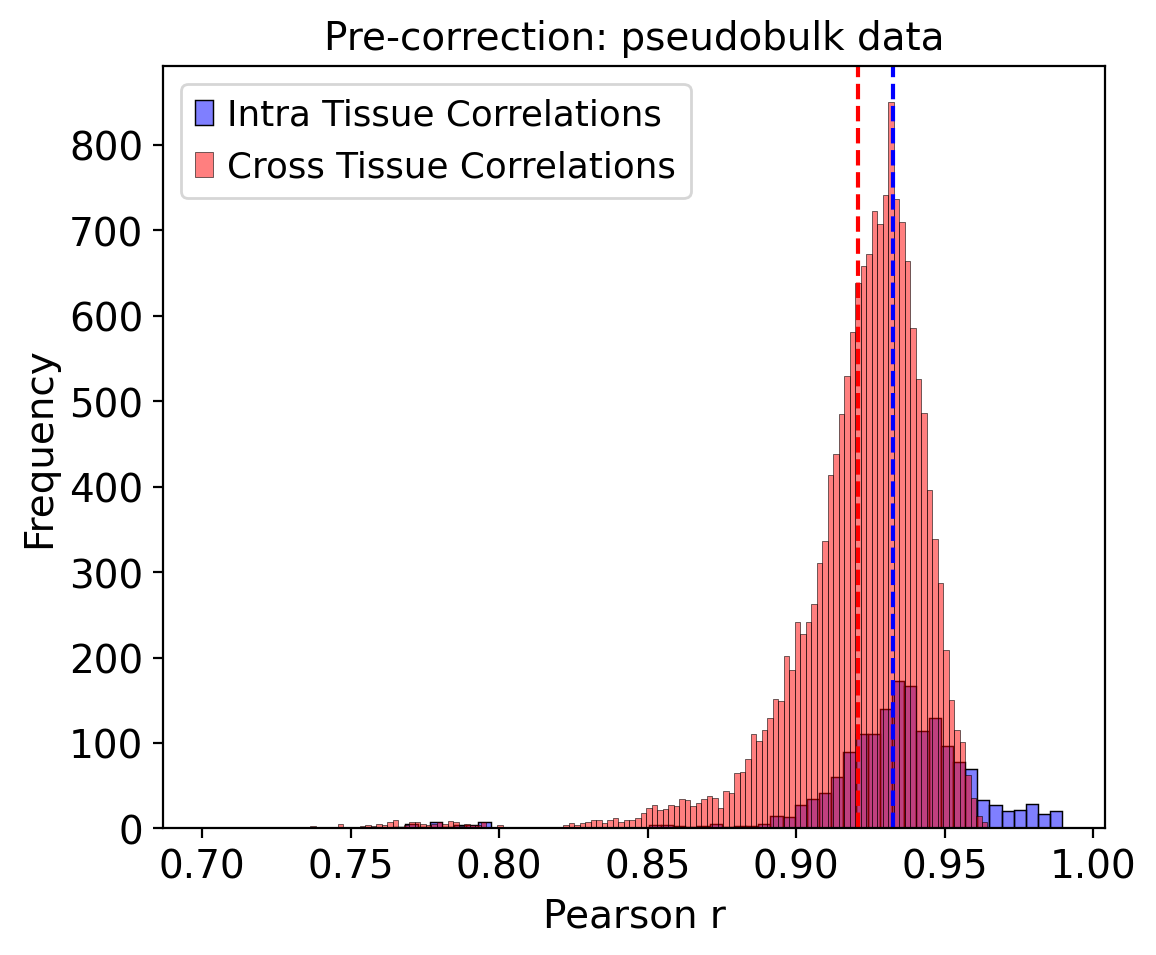

In [56]:
pbulk_cmat = cmat.loc["sc pseudoclones"].dropna(axis=1)
mask = np.triu(np.ones(pbulk_cmat.shape), k=1).astype(bool)
cmat_upper = pbulk_cmat.where(mask)
pbulk_corr = cmat_upper.stack().reset_index()
pbulk_corr.columns = ["idx_1", "idx_2", "corr"]
pbulk_corr["tissue_1"] = pbulk_corr["idx_1"].map(tissue_map)
pbulk_corr["tissue_2"] = pbulk_corr["idx_2"].map(tissue_map)
intra_tissue_corrs = pbulk_corr[pbulk_corr["tissue_1"] == pbulk_corr["tissue_2"]]["corr"]
cross_tissue_corrs = pbulk_corr[pbulk_corr["tissue_1"] != pbulk_corr["tissue_2"]]["corr"]
plt.figure(figsize=(6, 5))
mean_intra = np.mean(intra_tissue_corrs)
mean_cross = np.mean(cross_tissue_corrs)
sns.histplot(intra_tissue_corrs, color="blue", label="Intra Tissue Correlations", fill=True, alpha=.5)
sns.histplot(cross_tissue_corrs, color="red", label="Cross Tissue Correlations", fill=True, alpha=.5)
plt.axvline(mean_intra, color='blue', linestyle='--')
plt.axvline(mean_cross, color='red', linestyle='--')
plt.title("Pre-correction: pseudobulk data")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

In [57]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(intra_tissue_corrs, cross_tissue_corrs)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: 17.776, p-value: 4.239e-70


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


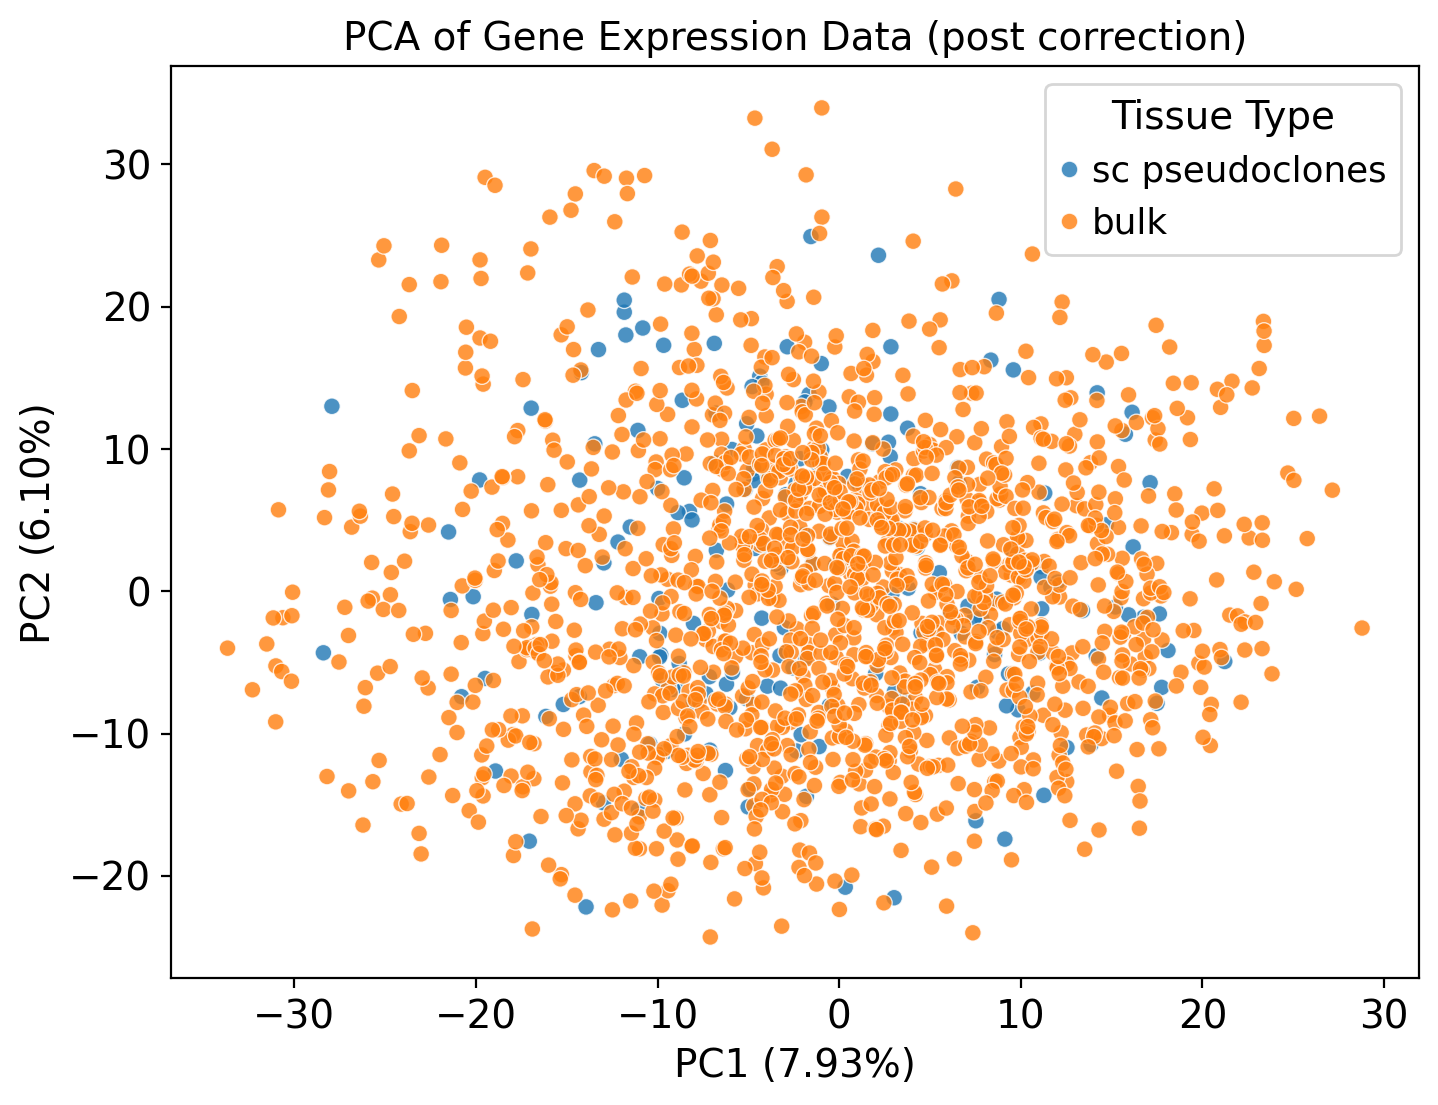

In [36]:
# Correct batch effect

from combat.pycombat import pycombat

np.random.seed(42)
corrected = pycombat(dataset_C.iloc[:,:-3].T, dataset_C["type"])

scaler = StandardScaler()
scaled_corrected_df = scaler.fit_transform(corrected.T)

pca = PCA(n_components=25)
pc_transformed = pca.fit_transform(scaled_corrected_df.T)

# Compute variance explained in percentage
explained_variance = pca.explained_variance_ratio_ * 100

# Create DataFrame with labeled PCs including variance explained
df_pca = pd.DataFrame(pc_transformed, columns=[f"PC{i+1} ({var:.2f}%)" for i, var in enumerate(explained_variance)])

# Reset index for merging with dataset_C
df_pca = df_pca.reset_index(drop=True)
dataset_C = dataset_C.reset_index(drop=True)

df_pca["type"] = dataset_C["type"]

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df_pca, x=df_pca.columns[0], y=df_pca.columns[1], hue="type", alpha=0.8, ax=ax)
plt.title("PCA of Gene Expression Data (post correction)")
plt.legend(title="Tissue Type")
plt.grid()
plt.show()

pdf_path = "/group/iorio/Raffaele/SCDRESP_data/data/figures/pca_postcorrection.pdf"
fig.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
plt.close(fig)


In [37]:
corrected = corrected.T
corrected["type"] = dataset_C["type"]
corrected["SangerModelID"] = dataset_C["SangerModelID"]
corrected["tissue"] = dataset_C["tissue"]

In [40]:
scaler = StandardScaler()
corrected_scaled = pd.DataFrame(scaler.fit_transform(corrected.iloc[:,:-3]))
corrected_scaled["type"] = dataset_C["type"]
cmat = corrected_scaled.groupby("type").apply(lambda g: g.iloc[:, :-1].T.corr())
tissue_map = dict(zip(dataset_C.index, dataset_C["tissue"].values))

/tmp/ipykernel_666125/2495848909.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cmat = corrected_scaled.groupby("type").apply(lambda g: g.iloc[:, :-1].T.corr())


In [ ]:
bulk_cmat = cmat.loc["bulk"].dropna(axis=1)
mask = np.triu(np.ones(bulk_cmat.shape), k=1).astype(bool)
cmat_upper = bulk_cmat.where(mask)
bulk_corr = cmat_upper.stack().reset_index()
bulk_corr.columns = ["idx_1", "idx_2", "corr"]
bulk_corr["tissue_1"] = bulk_corr["idx_1"].map(tissue_map)
bulk_corr["tissue_2"] = bulk_corr["idx_2"].map(tissue_map)
intra_tissue_corrs = bulk_corr[bulk_corr["tissue_1"] == bulk_corr["tissue_2"]]["corr"]
cross_tissue_corrs = bulk_corr[bulk_corr["tissue_1"] != bulk_corr["tissue_2"]]["corr"]
plt.figure(figsize=(6, 5))
mean_intra = np.mean(intra_tissue_corrs)
mean_cross = np.mean(cross_tissue_corrs)
sns.histplot(intra_tissue_corrs, color="blue", label="Intra Tissue Correlations", fill=True, alpha=.5)
sns.histplot(cross_tissue_corrs, color="red", label="Cross Tissue Correlations", fill=True, alpha=.5)
plt.axvline(mean_intra, color='blue', linestyle='--')
plt.axvline(mean_cross, color='red', linestyle='--')
plt.title("Post-correction: bulk data")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

In [30]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(intra_tissue_corrs, cross_tissue_corrs)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: 373.863, p-value: 0.000e+00


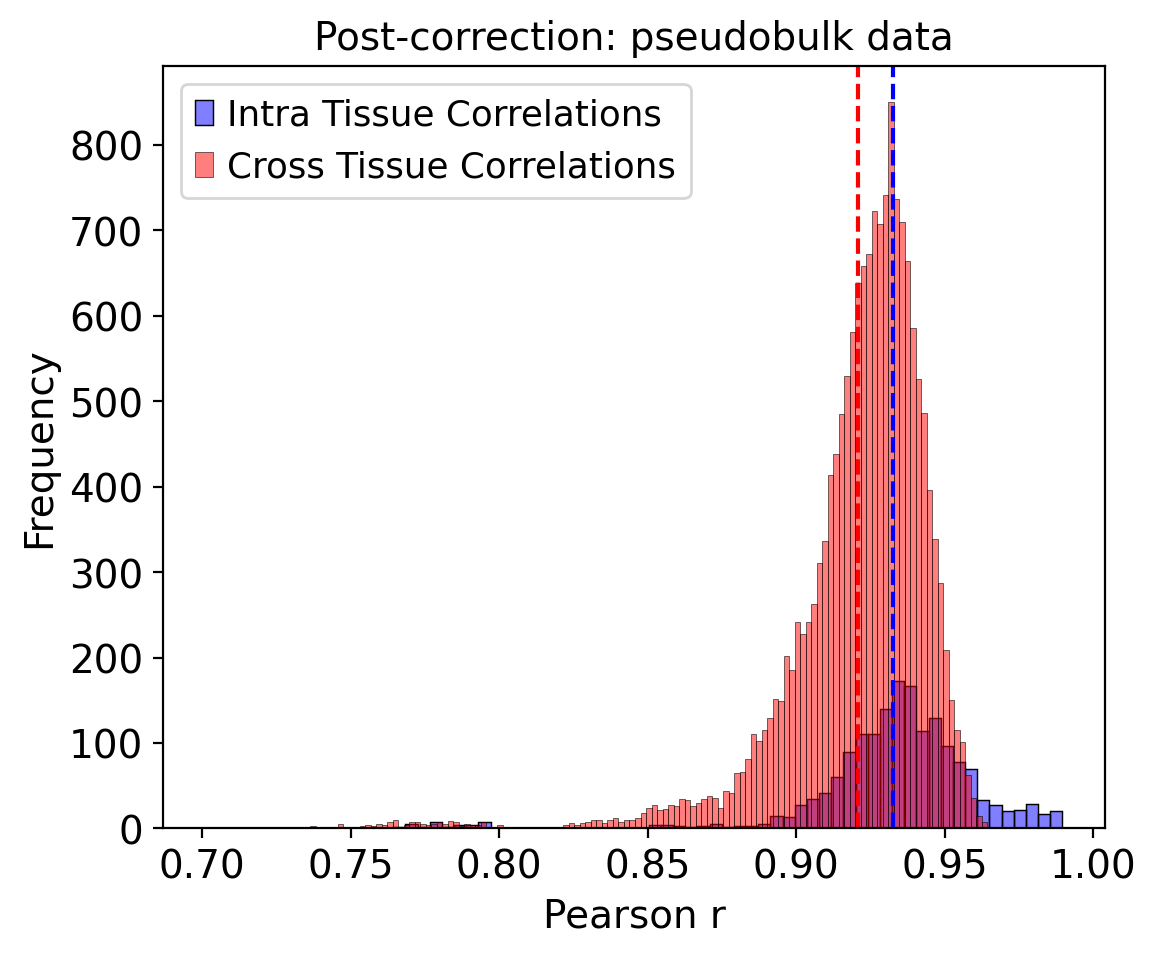

In [31]:
pbulk_cmat = cmat.loc["sc pseudoclones"].dropna(axis=1)
mask = np.triu(np.ones(pbulk_cmat.shape), k=1).astype(bool)
cmat_upper = pbulk_cmat.where(mask)
pbulk_corr = cmat_upper.stack().reset_index()
pbulk_corr.columns = ["idx_1", "idx_2", "corr"]
pbulk_corr["tissue_1"] = pbulk_corr["idx_1"].map(tissue_map)
pbulk_corr["tissue_2"] = pbulk_corr["idx_2"].map(tissue_map)
intra_tissue_corrs = pbulk_corr[pbulk_corr["tissue_1"] == pbulk_corr["tissue_2"]]["corr"]
cross_tissue_corrs = pbulk_corr[pbulk_corr["tissue_1"] != pbulk_corr["tissue_2"]]["corr"]
plt.figure(figsize=(6, 5))
mean_intra = np.mean(intra_tissue_corrs)
mean_cross = np.mean(cross_tissue_corrs)
sns.histplot(intra_tissue_corrs, color="blue", label="Intra Tissue Correlations", fill=True, alpha=.5)
sns.histplot(cross_tissue_corrs, color="red", label="Cross Tissue Correlations", fill=True, alpha=.5)
plt.axvline(mean_intra, color='blue', linestyle='--')
plt.axvline(mean_cross, color='red', linestyle='--')
plt.title("Post-correction: pseudobulk data")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

In [74]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(intra_tissue_corrs, cross_tissue_corrs)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: 63.507, p-value: 0.000e+00


In [62]:
integrated_pseudoclones = sc.AnnData(corrected.transpose())

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [64]:
series_tissue_total = pd.concat([dataset_A["tissue"],gex_extended["OncotreeLineage"]])
integrated_pseudoclones.obs["tissue"] = series_tissue_total.values
integrated_pseudoclones.obs["type"] = dataset_C["type"].values

In [63]:
sc.pp.highly_variable_genes(integrated_pseudoclones, flavor='seurat', n_top_genes=2000)
sc.tl.pca(integrated_pseudoclones, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(integrated_pseudoclones, n_neighbors=10, n_pcs=25)
sc.tl.umap(integrated_pseudoclones)

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Get UMAP coordinates
umap_coords = integrated_pseudoclones.obsm['X_umap']
df_umaps=pd.DataFrame(umap_coords, columns=["UMAP1","UMAP2"])
df_umaps["tissue"] = integrated_pseudoclones.obs['tissue'].values
df_umaps["types"] = integrated_pseudoclones.obs['type'].values

In [ ]:
#df_umaps['edgecolor'] = df_umaps['types'].apply(lambda x: 'black' if x == 'sc pseudoclones' else 'none')

#Create the scatterplot
#sns.scatterplot(
#    data=df_umaps, 
#    x="UMAP1", 
#    y="UMAP2", 
#    hue="tissue",  
#    style="types",  # Different markers for 'types'   # Size points according to 'types'
#    sizes=(150, 10),  # Increase size range
#    alpha=0.5,
#   edgecolor=df_umaps['edgecolor'] # Increase transparency for overlapping points
#)
#plt.legend(title='Tissue and Type', loc='upper left', bbox_to_anchor=(1, 1))
#plt.grid(None)

In [75]:
sc_gex_corrected = corrected[corrected["type"] == "sc pseudoclones"]
sc_gex_corrected = sc_gex_corrected.drop(columns="type").reset_index(drop=True)
# Prepare unseen data
X_test_unseen = sc_gex_corrected.iloc[:,:-2].fillna(0).to_numpy()

In [76]:
features_X_test_unseen = sc_gex_corrected.drop(columns={"SangerModelID", "tissue"}).columns

In [77]:
gex_corrected = corrected[corrected["type"] == "bulk"]
gex_corrected = gex_corrected.drop(columns="type").reset_index(drop=True)
gex_corrected = gex_corrected.reset_index(drop=True)

In [79]:
drugs = set(gdsc["DRUG_NAME"].unique())

In [80]:
clines_gex = set(gex_corrected["SangerModelID"].unique())
genes_gex = gex_corrected.drop(columns={"SangerModelID", "tissue"}).columns

training_sets_dict = {}

for dname in drugs:
    dresp_sub_df = gdsc[gdsc["DRUG_NAME"] == dname]
    clines_dresp = set(dresp_sub_df["SangerModelID"].unique())
    clines_to_keep = clines_dresp & clines_gex

    if len(clines_to_keep) < 250:
        continue

    dresp_filtered = dresp_sub_df[dresp_sub_df["SangerModelID"].isin(clines_to_keep)]
    gex_filtered = gex_corrected[gex_corrected["SangerModelID"].isin(clines_to_keep)]
    
    df = gex_filtered.merge(dresp_filtered, on="SangerModelID", how="left")
    
    # Select lineage with at least 10 cell lines
    octype_counts = df["tissue"].value_counts()
    octype_counts = octype_counts[octype_counts > 10].index
    df = df[df["tissue"].isin(octype_counts)]

    # retain HVF
    X = df.loc[:, df.columns.isin(genes_gex)]
    cv = np.std(X, axis=0)/np.mean(X, axis=0)
    threshold = np.percentile(cv,90)
    hvf = cv[cv > threshold].index
    X_hvf = X.loc[:, X.columns.isin(hvf)]

    # Save filtered dataset
    training_sets_dict[dname] = {
        "OBS": df["SangerModelID"].reset_index(drop=True),
        "X": X_hvf.reset_index(drop=True),  # Retaining only HVF genes
        "Y": df["LN_IC50"].reset_index(drop=True),
        "Metadata": df[["tissue", "CELL_LINE_NAME", "PATHWAY_NAME", "COSMIC_ID"]].reset_index(drop=True)
    }


In [81]:
training_sets_dict

{'Sabutoclax': {'OBS': 0      SIDM00442
  1      SIDM00858
  2      SIDM00924
  3      SIDM01155
  4      SIDM00478
           ...    
  617    SIDM00863
  618    SIDM00381
  619    SIDM00448
  620    SIDM01132
  621    SIDM01039
  Name: SangerModelID, Length: 622, dtype: object,
  'X':          A1CF       A2M     A2ML1     AADAC     ABCA6     ABCA8     ABCB5  \
  0    0.106542  2.835807  0.119707  0.115906  0.573821  5.029601  0.158976   
  1    0.106542  0.270317  0.105761  0.077125  0.108306  0.156177  0.278355   
  2    0.118530  0.230033  0.495330  0.077125  0.121768  3.087993  0.143405   
  3    0.176777  4.123320  0.091677  0.441785  0.121768  0.142360  0.111802   
  4    0.082209  0.072389  0.939293  0.202212  0.121768  0.100090  0.362371   
  ..        ...       ...       ...       ...       ...       ...       ...   
  617  0.146017  0.631487  0.095383  0.119886  3.162390  0.315070  0.072332   
  618  0.146017  0.123722  0.095383  0.191294  0.085541  0.077161  0.072332   
  6

In [82]:
with open("/group/iorio/Raffaele/SCDRESP_data/data/training_sets_dict.pkl", "wb") as f:
    pickle.dump(training_sets_dict, f)

In [85]:
len(training_sets_dict)

272

In [86]:
path_to_pkl = "/group/iorio/Raffaele/SCDRESP_data/data/results/elnet_rep1/"

# Dictionary to store loaded models with drug names as keys
models_dict = {}

# Regular expression pattern to extract the drug name from the filename
pattern = r"elastic_net_model_(.+)\.pkl"

for file in os.listdir(path_to_pkl):
    if file.endswith(".pkl"): 
        match = re.match(pattern, file)  
        if match:
            drug_name = match.group(1)  
            file_path = os.path.join(path_to_pkl, file)
            
            with open(file_path, "rb") as f:
                models_dict[drug_name] = pickle.load(f)

In [87]:
X_test_unseen = pd.DataFrame(X_test_unseen, columns=features_X_test_unseen)

In [88]:
predictions_dict = {}
for drug_name, model in models_dict.items():
    print(f"drug: {drug_name}")
    elnet_fit = model["model"]
    df = pd.DataFrame({"mean":pd.Series(model["scaler_mean"]).values,"scale":pd.Series(model["scaler_scale"]).values}, index=model["pre_filter_features"])
    #print(df.index)
    df = df[df.index.isin(model["post_filter_features"])]
    X_test_filtered = X_test_unseen.reindex(columns=df.index)
    print(X_test_filtered.columns) # genes
    print(df["mean"])
    print(df["scale"])
    X_test_scaled = (X_test_filtered - df["mean"])/df["scale"]
    #print(X_test_scaled.index)
    predictions = elnet_fit.predict(X_test_scaled)
    # Store predictions
    predictions_dict[drug_name] = predictions

drug: JAK_8517
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1651)
A1CF      0.330619
A2M       0.782209
A2ML1     0.423770
AADAC     0.623810
ABCA6     0.384379
            ...   
ZNF208    0.420341
ZNF536    0.332125
ZNF560    0.375773
ZNF676    0.328010
ZNF98     0.428719
Name: mean, Length: 1651, dtype: float64
A1CF      0.736693
A2M       1.582326
A2ML1     0.895954
AADAC     1.129826
ABCA6     0.713449
            ...   
ZNF208    0.798834
ZNF536    0.672316
ZNF560    0.754973
ZNF676    0.598009
ZNF98     0.779840
Name: scale, Length: 1651, dtype: float64
drug: BI-2536
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC8',
       'ABCC9', 'ABCD2',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98']

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: VE821
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC8',
       'ABCC9', 'ABCD2',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.309010
A2M       0.845963
A2ML1     0.424339
AADAC     0.597845
ABCA6     0.379415
            ...   
ZNF208    0.423478
ZNF536    0.369947
ZNF560    0.383229
ZNF676    0.324717
ZNF98     0.419798
Name: mean, Length: 1653, dtype: float64
A1CF      0.714940
A2M       1.745922
A2ML1     0.878157
AADAC     1.086242
ABCA6     0.690218
            ...   
ZNF208    0.816731
ZNF536    0.752070
ZNF560    0.755828
ZNF676    0.590852
ZNF98     0.776561
Name: scale, Length: 1653, dtype: float64
drug: Motesanib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: BPD-00008900
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC8',
       'ABCC9', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1651)
A1CF      0.312610
A2M       0.783399
A2ML1     0.431666
AADAC     0.620376
ABCA6     0.373180
            ...   
ZNF208    0.423705
ZNF536    0.343568
ZNF560    0.373532
ZNF676    0.333269
ZNF98     0.428547
Name: mean, Length: 1651, dtype: float64
A1CF      0.710370
A2M       1.575980
A2ML1     0.891672
AADAC     1.124478
ABCA6     0.700091
            ...   
ZNF208    0.812929
ZNF536    0.686179
ZNF560    0.749197
ZNF676    0.609941
ZNF98     0.778194
Name: scale, Length: 1651, dtype: float64
drug: Osimertinib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', '

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.311247
A2M       0.836079
A2ML1     0.416670
AADAC     0.595693
ABCA6     0.377091
            ...   
ZNF208    0.432136
ZNF536    0.376963
ZNF560    0.386556
ZNF676    0.330665
ZNF98     0.417380
Name: mean, Length: 1653, dtype: float64
A1CF      0.716843
A2M       1.737353
A2ML1     0.858693
AADAC     1.080654
ABCA6     0.686560
            ...   
ZNF208    0.837648
ZNF536    0.766995
ZNF560    0.758189
ZNF676    0.602991
ZNF98     0.774194
Name: scale, Length: 1653, dtype: float64
drug: Ribociclib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC8',
       'ABCC9', 'ABCD2',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtyp

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Temozolomide
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.311440
A2M       0.835839
A2ML1     0.422765
AADAC     0.596980
ABCA6     0.375803
            ...   
ZNF208    0.430431
ZNF536    0.377583
ZNF560    0.389356
ZNF676    0.329221
ZNF98     0.417327
Name: mean, Length: 1653, dtype: float64
A1CF      0.715344
A2M       1.731893
A2ML1     0.872670
AADAC     1.082354
ABCA6     0.684214
            ...   
ZNF208    0.834853
ZNF536    0.766146
ZNF560    0.764100
ZNF676    0.600983
ZNF98     0.772947
Name: scale, Length: 1653, dtype: float64
drug: THR-103
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC8',
       'ABCC9', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF9

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.711124
A2M       1.658800
A2ML1     0.873178
AADAC     1.103162
ABCA6     0.688572
            ...   
ZNF208    0.827782
ZNF536    0.727421
ZNF560    0.773412
ZNF676    0.614644
ZNF98     0.797023
Name: scale, Length: 1651, dtype: float64
drug: 741909
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1651)
A1CF      0.322974
A2M       0.785807
A2ML1     0.423830
AADAC     0.627851
ABCA6     0.385089
            ...   
ZNF208    0.420806
ZNF536    0.333322
ZNF560    0.377178
ZNF676    0.328707
ZNF98     0.428218
Name: mean, Length: 1651, dtype: float64
A1CF      0.713084
A2M       1.586107
A2ML1     0.898271
AADAC     1.132009
ABCA6     0.715360
            ...   
ZNF208    0.800764
ZNF536    0.674045
ZNF560    0.756896
ZNF676    0.599625
ZNF98     0.780939
Name: scale, Length: 165

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Dinaciclib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1651)
A1CF      0.310035
A2M       0.819367
A2ML1     0.417056
AADAC     0.602532
ABCA6     0.389330
            ...   
ZNF208    0.429950
ZNF536    0.362831
ZNF560    0.388878
ZNF676    0.325588
ZNF98     0.428030
Name: mean, Length: 1651, dtype: float64
A1CF      0.697941
A2M       1.703257
A2ML1     0.877435
AADAC     1.091479
ABCA6     0.705285
            ...   
ZNF208    0.835877
ZNF536    0.742189
ZNF560    0.760458
ZNF676    0.593654
ZNF98     0.789429
Name: scale, Length: 1651, dtype: float64
drug: AZD5363
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.716843
A2M       1.737353
A2ML1     0.858693
AADAC     1.080654
ABCA6     0.686560
            ...   
ZNF208    0.837648
ZNF536    0.766995
ZNF560    0.758189
ZNF676    0.602991
ZNF98     0.774194
Name: scale, Length: 1653, dtype: float64
drug: THR-102
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC8',
       'ABCC9', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1651)
A1CF      0.314293
A2M       0.799572
A2ML1     0.430352
AADAC     0.628978
ABCA6     0.372163
            ...   
ZNF208    0.426577
ZNF536    0.345519
ZNF560    0.383703
ZNF676    0.335415
ZNF98     0.434144
Name: mean, Length: 1651, dtype: float64
A1CF      0.713946
A2M       1.587209
A2ML1     0.882101
AADAC     1.133188
ABCA6     0.697228
            ...   
ZNF208    0.818160
ZNF536    0.686218
ZNF560    0.765262
ZNF676    0.614170
ZNF98     0.784904
Name: scale, Length: 16

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Tamoxifen
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.311247
A2M       0.836079
A2ML1     0.416670
AADAC     0.595693
ABCA6     0.377091
            ...   
ZNF208    0.432136
ZNF536    0.376963
ZNF560    0.386556
ZNF676    0.330665
ZNF98     0.417380
Name: mean, Length: 1653, dtype: float64
A1CF      0.716843
A2M       1.737353
A2ML1     0.858693
AADAC     1.080654
ABCA6     0.686560
            ...   
ZNF208    0.837648
ZNF536    0.766995
ZNF560    0.758189
ZNF676    0.602991
ZNF98     0.774194
Name: scale, Length: 1653, dtype: float64
drug: Linsitinib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF9

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.710832
A2M       1.730719
A2ML1     0.865971
AADAC     1.080663
ABCA6     0.678924
            ...   
ZNF536    0.769850
ZNF560    0.766582
ZNF676    0.596665
ZNF98     0.770025
ZPLD1     0.456614
Name: scale, Length: 1653, dtype: float64
drug: MG-132
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98', 'ZPLD1'],
      dtype='object', length=1653)
A1CF      0.309977
A2M       0.839271
A2ML1     0.416913
AADAC     0.596402
ABCA6     0.372798
            ...   
ZNF536    0.380156
ZNF560    0.391669
ZNF676    0.326823
ZNF98     0.416353
ZPLD1     0.252391
Name: mean, Length: 1653, dtype: float64
A1CF      0.710355
A2M       1.729658
A2ML1     0.865383
AADAC     1.080007
ABCA6     0.678504
            ...   
ZNF536    0.769364
ZNF560    0.766087
ZNF676    0.596287
ZNF98     0.769467
ZPLD1     0.456299
Name: scale, Length: 165

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: PD173074
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.311135
A2M       0.834814
A2ML1     0.422416
AADAC     0.596321
ABCA6     0.375405
            ...   
ZNF208    0.429966
ZNF536    0.377164
ZNF560    0.388971
ZNF676    0.328894
ZNF98     0.417425
Name: mean, Length: 1653, dtype: float64
A1CF      0.714855
A2M       1.730810
A2ML1     0.872069
AADAC     1.081684
ABCA6     0.683784
            ...   
ZNF208    0.834319
ZNF536    0.765654
ZNF560    0.763598
ZNF676    0.600596
ZNF98     0.772376
Name: scale, Length: 1653, dtype: float64
drug: Podophyllotoxin bromide
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZN

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.313431
A2M       0.841448
A2ML1     0.423966
AADAC     0.602194
ABCA6     0.373231
            ...   
ZNF208    0.425539
ZNF536    0.372326
ZNF560    0.387928
ZNF676    0.328997
ZNF98     0.411431
Name: mean, Length: 1653, dtype: float64
A1CF      0.718819
A2M       1.739992
A2ML1     0.876519
AADAC     1.086832
ABCA6     0.681113
            ...   
ZNF208    0.833846
ZNF536    0.758043
ZNF560    0.761915
ZNF676    0.603684
ZNF98     0.768234
Name: scale, Length: 1653, dtype: float64
drug: Ulixertinib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.311795
A2M       0.811051
A2ML1     0.421329
AADAC     0.606016
ABCA6     0.371371
            ...   
ZNF208    0.434973
ZNF536    0.359652
ZNF560    0.394829
ZNF676    0.337949
ZNF98     0.429970
Name: mean, Length:

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: SCH772984
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.312082
A2M       0.838828
A2ML1     0.423259
AADAC     0.600582
ABCA6     0.372211
            ...   
ZNF208    0.430753
ZNF536    0.377737
ZNF560    0.389767
ZNF676    0.329507
ZNF98     0.417688
Name: mean, Length: 1653, dtype: float64
A1CF      0.715773
A2M       1.735288
A2ML1     0.873226
AADAC     1.084345
ABCA6     0.679329
            ...   
ZNF208    0.835430
ZNF536    0.766702
ZNF560    0.764596
ZNF676    0.601385
ZNF98     0.773466
Name: scale, Length: 1653, dtype: float64
drug: LCL161
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC9',
       'ABCD2', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.719316
A2M       1.746293
A2ML1     0.850175
AADAC     1.086986
ABCA6     0.683527
            ...   
ZNF208    0.842041
ZNF536    0.767479
ZNF560    0.770652
ZNF676    0.605958
ZNF98     0.779438
Name: scale, Length: 1651, dtype: float64
drug: Pyridostatin
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCA8', 'ABCB5', 'ABCC8',
       'ABCC9', 'ABCD2',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.310165
A2M       0.843315
A2ML1     0.423535
AADAC     0.597347
ABCA6     0.378801
            ...   
ZNF208    0.434109
ZNF536    0.374488
ZNF560    0.393363
ZNF676    0.331231
ZNF98     0.415995
Name: mean, Length: 1653, dtype: float64
A1CF      0.717064
A2M       1.742828
A2ML1     0.876984
AADAC     1.084219
ABCA6     0.688811
            ...   
ZNF208    0.840350
ZNF536    0.763419
ZNF560    0.769140
ZNF676    0.604978
ZNF98     0.774365
Name: scale, Leng

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(


In [89]:
df_pred = pd.DataFrame(predictions_dict)
df_pred["SangerModelID"] = dataset_A["SangerModelID"].values
df_pred["tissue"] = dataset_A["tissue"].values

In [91]:
df_pred.to_csv("/group/iorio/Raffaele/SCDRESP_data/data/psclones_dresp_predictions_rep1.csv")